## Import libs

In [1]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Plotting functions

In [2]:
# following function source: 
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Load data

In [3]:
# Only from patient 01
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed signal and create labels(pre ictal label is 1 && inter ictal label is 0)
# pre_ictal = np.load('pre_ictal_pca.npy')
# inter_ictal = np.load('inter_ictal_pca.npy')
pre_ictal = np.load('Patient01_siz_input.npy')
inter_ictal = np.load('Patient01_int_input.npy')
pre_ictal_label = np.ones(np.size(pre_ictal, axis=0))
inter_ictal_label = np.zeros(np.size(inter_ictal, axis=0))

# concate pre_ictal and inter_ictal
trainset = np.concatenate((pre_ictal, inter_ictal), axis=0)
labelset = np.concatenate((pre_ictal_label, inter_ictal_label), 
                         axis=0)

# onehot encoding labels
labelset_onehot = np.zeros((np.size(labelset), int(np.max(labelset))+1))
labelset_onehot[np.arange(labelset.size), labelset.astype(int)]  = 1

# Split them into train and test set
X_train, X_test, y_train, y_test = train_test_split(trainset, labelset_onehot,
                                                   test_size=0.2,
                                                   random_state=66,
                                                   shuffle=True)

In [4]:
# Combine 01 & 07
import numpy as np
from sklearn.model_selection import train_test_split

# --------------------------------------------Patient 01 as train------------------------------------------
# Load preprocessed signal and create labels(pre ictal label is 1 && inter ictal label is 0)
# pre_ictal = np.load('pre_ictal_pca.npy')
# inter_ictal = np.load('inter_ictal_pca.npy')
pre_ictal = np.load('Patient01_siz_input.npy')
inter_ictal = np.load('Patient01_int_input.npy')
pre_ictal_label = np.ones(np.size(pre_ictal, axis=0))
inter_ictal_label = np.zeros(np.size(inter_ictal, axis=0))

# concate pre_ictal and inter_ictal
trainset = np.concatenate((pre_ictal, inter_ictal), axis=0)
labelset = np.concatenate((pre_ictal_label, inter_ictal_label), 
                         axis=0)

# onehot encoding labels
labelset_onehot = np.zeros((np.size(labelset), int(np.max(labelset))+1))
labelset_onehot[np.arange(labelset.size), labelset.astype(int)]  = 1

X_train = trainset
y_train = labelset_onehot
# X_test = trainset
# y_test = labelset_onehot

# -------------------------------Patient 07 as test------------------------------------------------

pre_ictal = np.load('Patient07_siz_input.npy')
inter_ictal = np.load('Patient07_int_input.npy')
pre_ictal_label = np.ones(np.size(pre_ictal, axis=0))
inter_ictal_label = np.zeros(np.size(inter_ictal, axis=0))

# concate pre_ictal and inter_ictal
trainset = np.concatenate((pre_ictal, inter_ictal), axis=0)
labelset = np.concatenate((pre_ictal_label, inter_ictal_label), 
                         axis=0)

# onehot encoding labels
labelset_onehot = np.zeros((np.size(labelset), int(np.max(labelset))+1))
labelset_onehot[np.arange(labelset.size), labelset.astype(int)]  = 1

X_test = trainset
y_test = labelset_onehot
# X_train = trainset
# y_train = labelset_onehot


#-------------------------------concat 01 & 07 -------------------------------------------------------
trainset = np.concatenate((X_train,X_test), axis = 0)
labelset_onehot = np.concatenate((y_train, y_test), axis=0)
# # Split them into train and test set
# X_train, X_test, y_train, y_test = train_test_split(trainset, labelset_onehot,
#                                                    test_size=0.2,
#                                                    random_state=66,
#                                                    shuffle=True)



In [7]:
import random
def balance(data, label):  # a class minor, b class more data
    X_train = data
    y_train = label
    X_train_pre_ictal_data = X_train[(np.where(np.argmax(y_train, axis=1) == 1)[0]),:]   # X_train pre-ictal data   DEL
    X_train_pre_ictal_label = y_train[(np.where(np.argmax(y_train, axis=1) == 1)[0]),:]   # X_train pre-ictal label    DEL

    X_train_int_ictal_data = X_train[(np.where(np.argmax(y_train, axis=1) == 0)[0]),:]    # X_train inter-ictal data    DEL
    X_train_int_ictal_label = y_train[(np.where(np.argmax(y_train, axis=1) == 0)[0]),:]     # X_train inter-ictal label     DEL


    random_index = np.array(random.sample(range(0, X_train_int_ictal_data.shape[0]), k= X_train_pre_ictal_data.shape[0]))
    X_train_int_ictal_data_select = X_train_int_ictal_data[random_index, :]
    X_train_int_ictal_label_select = X_train_int_ictal_label[random_index, :]
    
    return X_train_pre_ictal_data, X_train_pre_ictal_label, X_train_int_ictal_data_select, X_train_int_ictal_label_select

In [8]:
# Create X_train, y_train, representing patient 01
X_train_pre_ictal_data, X_train_pre_ictal_label, \
X_train_int_ictal_data_select, X_train_int_ictal_label_select = balance(X_train,y_train)
trainset = np.concatenate((X_train_pre_ictal_data, X_train_int_ictal_data_select), axis=0)
labelset = np.concatenate((X_train_pre_ictal_label, X_train_int_ictal_label_select), 
                         axis=0)

X_train = trainset; y_train = labelset

In [9]:
# Create X_test, y_test, representing patient 07
X_test_pre_ictal_data, X_test_pre_ictal_label, \
X_test_int_ictal_data_select, X_test_int_ictal_label_select = balance(X_test,y_test)
trainset = np.concatenate((X_test_pre_ictal_data, X_test_int_ictal_data_select), axis=0)
labelset = np.concatenate((X_test_pre_ictal_label, X_test_int_ictal_label_select), 
                         axis=0)

X_test = trainset; y_test = labelset

In [10]:
trainset = np.concatenate((X_train,X_test), axis = 0)
labelset_onehot = np.concatenate((y_train, y_test), axis=0)
# Split them into train and test set
X_train, X_test, y_train, y_test = train_test_split(trainset, labelset_onehot,
                                                   test_size=0.2,
                                                   random_state=66,
                                                   shuffle=True)

<BarContainer object of 2 artists>

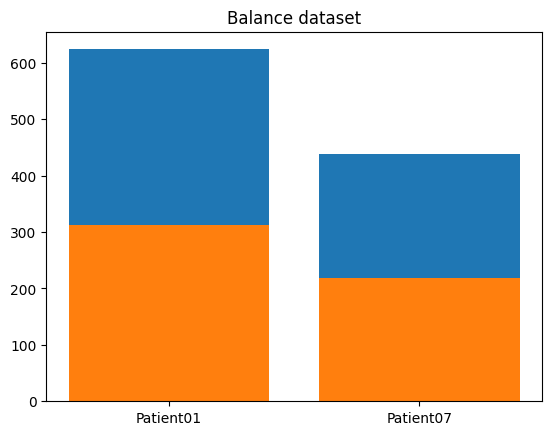

In [107]:
# plt.figure()
# plt.title('Balance dataset')
# plt.bar(np.arange(1,3), [624,438], label = 'Inter-ictal', tick_label = ['Patient01', 'Patient07'])
# plt.bar(np.arange(1,3), [312,219], label = 'Pre-ictal')

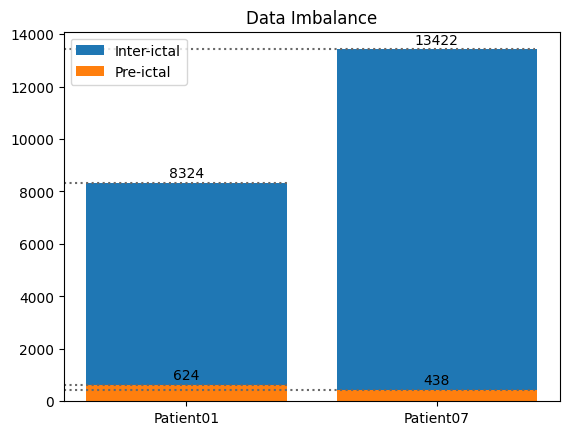

In [4]:
plt.figure()
plt.title('Data Imbalance')
plt.bar(np.arange(1,3), np.append(np.where(y_train == [0,1])[0].shape[0] + np.where(y_train == [1,0])[0].shape[0],
                                np.where(y_test == [0,1])[0].shape[0] + np.where(y_test == [1,0])[0].shape[0]),
        label = 'Inter-ictal',
        tick_label = ['Patient01', 'Patient07'])
plt.bar(np.arange(1,3), np.append(np.where(y_train == [0,1])[0].shape[0], np.where(y_test == [0,1])[0].shape[0]), label = 'Pre-ictal')

y_stick = [np.where(y_train == [0,1])[0].shape[0],
          np.where(y_train == [0,1])[0].shape[0] + np.where(y_train == [1,0])[0].shape[0],
          np.where(y_test == [0,1])[0].shape[0],
          np.where(y_test == [0,1])[0].shape[0] + np.where(y_test == [1,0])[0].shape[0]]

plt.axhline(y=np.where(y_train == [0,1])[0].shape[0], 
            xmin=0, xmax=0.45, linestyle=':',c=mcolors.CSS4_COLORS['dimgray'])
plt.text(1,624+200,'624', ha='center')

plt.axhline(y=8324, 
            xmin=0, xmax=0.45, linestyle=':',c=mcolors.CSS4_COLORS['dimgray'])
plt.text(1,8324+200,'8324', ha='center')

plt.axhline(y=438, 
            xmin=0, xmax=0.95, linestyle=':',c=mcolors.CSS4_COLORS['dimgray'])
plt.text(2,438+200,'438', ha='center')

plt.axhline(y=13422, 
            xmin=0, xmax=0.95, linestyle=':',c=mcolors.CSS4_COLORS['dimgray'])
plt.text(2,13422+200,'13422', ha='center')

plt.legend()
plt.show()

# Network 
Reference link: https://github.com/coreylammie/Memristive-Seizure-Detection-and-Prediction-by-Parallel-Convolutional-Neural-Networks/blob/master/network_training/Network.py

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import brevitas.nn as qnn
from torch.utils.data import DataLoader, TensorDataset


### Network Definition
class ParallelConvolution(nn.Module):
    def __init__(self, size=32):
        super(ParallelConvolution, self).__init__()
        self.conv1 = qnn.QuantConv1d(1,32,size,weight_bit_width=6)
        self.conv2 = qnn.QuantConv1d(1,32,62-size,weight_bit_width=6)
        self.avgpool = nn.AvgPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = qnn.QuantLinear(1088,8,bias=True,weight_bit_width=4)
        self.classification = qnn.QuantLinear(8,2,bias=True,weight_bit_width=4)
# comment: This code use QuantConv1d rather than nn.conv1d.quantization aware training allowing 
# you to train deep neural netowrks with low-bit precision activations and weights which allows to save computational resources.

    def forward(self,x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(x))
        x = torch.cat((out1, out2),dim=2)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        out = self.classification(x)
        return out

In [14]:
# Running on GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device),'\n')

# Identify network size
network_size = 32
network = ParallelConvolution(size=network_size).to(device, dtype=torch.float)

# Identify dataset
dataset = TensorDataset(torch.Tensor(X_train[:,np.newaxis,:]),
                        torch.Tensor(y_train))
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

loss_function = nn.BCEWithLogitsLoss()  # LOSS FUNCTION????
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)





num_epochs = 100
for epoch in range(num_epochs):
    network.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = network(inputs)
        
            
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        network.eval()
        
        running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)}")

#         outputs = outputs.cpu().detach().numpy()
#         labels = labels.cpu().detach().numpy()
#         outputs = np.argmax(outputs,axis=1)
#         labels = np.argmax(labels,axis=1)
#         trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, labels, labels=[0, 1]))
#         trainCorrect += np.sum(outputs==labels)
#         trainTotal += len(outputs)
#         trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
#         trainLabels = np.append(trainLabels,labels.reshape((-1,1)),axis=0)

Using cpu device 

Epoch [1/100] Loss: 0.05054484946387155
Epoch [1/100] Loss: 0.09930989997727531
Epoch [1/100] Loss: 0.14722172277314322
Epoch [1/100] Loss: 0.19696361677987234
Epoch [1/100] Loss: 0.2470097201211112
Epoch [1/100] Loss: 0.2965308896132878
Epoch [1/100] Loss: 0.3460364171436855
Epoch [1/100] Loss: 0.39531370997428894
Epoch [1/100] Loss: 0.44413975306919645
Epoch [1/100] Loss: 0.49302829589162556
Epoch [1/100] Loss: 0.5424213579722813
Epoch [1/100] Loss: 0.5911890353475299
Epoch [1/100] Loss: 0.6395399655614581
Epoch [1/100] Loss: 0.6882849420819964
Epoch [2/100] Loss: 0.04882924045835223
Epoch [2/100] Loss: 0.09667060204914638
Epoch [2/100] Loss: 0.14422996555055892
Epoch [2/100] Loss: 0.19255749242646353
Epoch [2/100] Loss: 0.24097718937056406
Epoch [2/100] Loss: 0.28948245303971426
Epoch [2/100] Loss: 0.33836414558546885
Epoch [2/100] Loss: 0.3859577306679317
Epoch [2/100] Loss: 0.4333138508456094
Epoch [2/100] Loss: 0.4802024705069406
Epoch [2/100] Loss: 0.526915890

Epoch [17/100] Loss: 0.27962468777384075
Epoch [17/100] Loss: 0.3111312431948526
Epoch [17/100] Loss: 0.3358630623136248
Epoch [17/100] Loss: 0.3747121734278543
Epoch [17/100] Loss: 0.3952558253492628
Epoch [18/100] Loss: 0.03595915862492153
Epoch [18/100] Loss: 0.06209597843033927
Epoch [18/100] Loss: 0.08301111204283577
Epoch [18/100] Loss: 0.1169595228774207
Epoch [18/100] Loss: 0.14337103494576045
Epoch [18/100] Loss: 0.17229965967791422
Epoch [18/100] Loss: 0.18934982270002365
Epoch [18/100] Loss: 0.21448829025030136
Epoch [18/100] Loss: 0.23844994072403228
Epoch [18/100] Loss: 0.27042189985513687
Epoch [18/100] Loss: 0.2971270627209118
Epoch [18/100] Loss: 0.32136552780866623
Epoch [18/100] Loss: 0.3483688820685659
Epoch [18/100] Loss: 0.3841605005519731
Epoch [19/100] Loss: 0.02458167714732034
Epoch [19/100] Loss: 0.05334356214318957
Epoch [19/100] Loss: 0.07977933755942754
Epoch [19/100] Loss: 0.10188340076378413
Epoch [19/100] Loss: 0.13378286148820603
Epoch [19/100] Loss: 0.1

Epoch [32/100] Loss: 0.27525696264845984
Epoch [33/100] Loss: 0.03900154147829328
Epoch [33/100] Loss: 0.05406650794403894
Epoch [33/100] Loss: 0.06860220219407763
Epoch [33/100] Loss: 0.08629854023456573
Epoch [33/100] Loss: 0.1054544448852539
Epoch [33/100] Loss: 0.12336311382906777
Epoch [33/100] Loss: 0.1462939658335277
Epoch [33/100] Loss: 0.16520702838897705
Epoch [33/100] Loss: 0.18332630395889282
Epoch [33/100] Loss: 0.19550739122288568
Epoch [33/100] Loss: 0.21668947275195802
Epoch [33/100] Loss: 0.2387108408979007
Epoch [33/100] Loss: 0.2575924109135355
Epoch [33/100] Loss: 0.27886499145201277
Epoch [34/100] Loss: 0.02651294640132359
Epoch [34/100] Loss: 0.043250871556145806
Epoch [34/100] Loss: 0.062160562191690714
Epoch [34/100] Loss: 0.07978867845875877
Epoch [34/100] Loss: 0.09974436887672969
Epoch [34/100] Loss: 0.11904221986021314
Epoch [34/100] Loss: 0.1331294679215976
Epoch [34/100] Loss: 0.14923754334449768
Epoch [34/100] Loss: 0.1675917421068464
Epoch [34/100] Loss:

Epoch [48/100] Loss: 0.08206157705613545
Epoch [48/100] Loss: 0.09822357658829008
Epoch [48/100] Loss: 0.1167836817247527
Epoch [48/100] Loss: 0.13295977136918477
Epoch [48/100] Loss: 0.15006270791803086
Epoch [48/100] Loss: 0.1636606486780303
Epoch [48/100] Loss: 0.17741419800690242
Epoch [48/100] Loss: 0.1918936116354806
Epoch [48/100] Loss: 0.2052363987479891
Epoch [48/100] Loss: 0.21840453360761916
Epoch [48/100] Loss: 0.22804471850395203
Epoch [49/100] Loss: 0.02758306690624782
Epoch [49/100] Loss: 0.039257475308009555
Epoch [49/100] Loss: 0.05429199231522424
Epoch [49/100] Loss: 0.06552181392908096
Epoch [49/100] Loss: 0.07796746279512133
Epoch [49/100] Loss: 0.08938586286136083
Epoch [49/100] Loss: 0.10127417636769158
Epoch [49/100] Loss: 0.12295214938265937
Epoch [49/100] Loss: 0.14744347227471216
Epoch [49/100] Loss: 0.16659868082829885
Epoch [49/100] Loss: 0.1797439700790814
Epoch [49/100] Loss: 0.19170002745730536
Epoch [49/100] Loss: 0.20481313658612116
Epoch [49/100] Loss:

Epoch [62/100] Loss: 0.16142597741314343
Epoch [62/100] Loss: 0.17150538680808886
Epoch [62/100] Loss: 0.1785668736057622
Epoch [62/100] Loss: 0.18834748598081724
Epoch [62/100] Loss: 0.19466822434748923
Epoch [63/100] Loss: 0.03472113609313965
Epoch [63/100] Loss: 0.04231775818126542
Epoch [63/100] Loss: 0.05573652844343867
Epoch [63/100] Loss: 0.06479865259357862
Epoch [63/100] Loss: 0.07840234520179885
Epoch [63/100] Loss: 0.0865948253444263
Epoch [63/100] Loss: 0.09531791188887187
Epoch [63/100] Loss: 0.10847291563238416
Epoch [63/100] Loss: 0.11787019563572747
Epoch [63/100] Loss: 0.12682622990437917
Epoch [63/100] Loss: 0.1414282683815275
Epoch [63/100] Loss: 0.15324431551354273
Epoch [63/100] Loss: 0.16840513263429915
Epoch [63/100] Loss: 0.1793442964553833
Epoch [64/100] Loss: 0.018334505813462392
Epoch [64/100] Loss: 0.03221812950713294
Epoch [64/100] Loss: 0.039878430111067634
Epoch [64/100] Loss: 0.05285136933837618
Epoch [64/100] Loss: 0.06199975631066731
Epoch [64/100] Los

Epoch [77/100] Loss: 0.024898192712238858
Epoch [77/100] Loss: 0.032998999314648766
Epoch [77/100] Loss: 0.0464287240590368
Epoch [77/100] Loss: 0.055951768798487525
Epoch [77/100] Loss: 0.06299044830458504
Epoch [77/100] Loss: 0.07453964544194085
Epoch [77/100] Loss: 0.08063507452607155
Epoch [77/100] Loss: 0.09135802462697029
Epoch [77/100] Loss: 0.09673065479312624
Epoch [77/100] Loss: 0.1051448934844562
Epoch [77/100] Loss: 0.10929187440446445
Epoch [77/100] Loss: 0.1199331735926015
Epoch [77/100] Loss: 0.1282032265194825
Epoch [77/100] Loss: 0.13356762272971018
Epoch [78/100] Loss: 0.04758709243365696
Epoch [78/100] Loss: 0.05604947251932962
Epoch [78/100] Loss: 0.06215642552290644
Epoch [78/100] Loss: 0.0729518633868013
Epoch [78/100] Loss: 0.08531466073223523
Epoch [78/100] Loss: 0.0973165136362825
Epoch [78/100] Loss: 0.10432315138833863
Epoch [78/100] Loss: 0.10902875608631543
Epoch [78/100] Loss: 0.11656800551073891
Epoch [78/100] Loss: 0.12491392397454806
Epoch [78/100] Loss

Epoch [91/100] Loss: 0.11861656020794596
Epoch [91/100] Loss: 0.12353817586387907
Epoch [91/100] Loss: 0.1332832628062793
Epoch [91/100] Loss: 0.1406342632004193
Epoch [91/100] Loss: 0.146982769880976
Epoch [91/100] Loss: 0.15204482632023947
Epoch [92/100] Loss: 0.04459361944879804
Epoch [92/100] Loss: 0.05167300945946148
Epoch [92/100] Loss: 0.05589191748627594
Epoch [92/100] Loss: 0.06289857386478356
Epoch [92/100] Loss: 0.06914993029619966
Epoch [92/100] Loss: 0.07575829140841961
Epoch [92/100] Loss: 0.08198573094393526
Epoch [92/100] Loss: 0.0953927356749773
Epoch [92/100] Loss: 0.10056767692523343
Epoch [92/100] Loss: 0.10965671895870141
Epoch [92/100] Loss: 0.12048800050147943
Epoch [92/100] Loss: 0.12642994017473289
Epoch [92/100] Loss: 0.13238591993493692
Epoch [92/100] Loss: 0.13598746194371156
Epoch [93/100] Loss: 0.08760654926300049
Epoch [93/100] Loss: 0.09118216138865266
Epoch [93/100] Loss: 0.09631472639739513
Epoch [93/100] Loss: 0.10178416994001184
Epoch [93/100] Loss: 

## Confusion matrix 

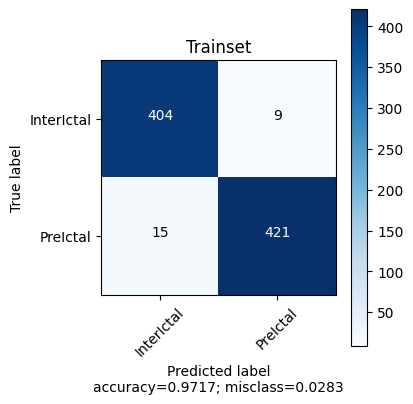

In [15]:
inputs = torch.Tensor(X_train[:,np.newaxis,:]).to(device, dtype=torch.float)
outputs = network(inputs)

outputs = outputs.cpu().detach().numpy()
outputs = np.argmax(outputs,axis=1)

plot_confusion_matrix(sklearn.metrics.confusion_matrix(outputs, np.argmax(y_train, axis=1)),
                     target_names=['InterIctal', 'PreIctal'],
                     cmap=None,
                     title='Trainset',
                     normalize=False)

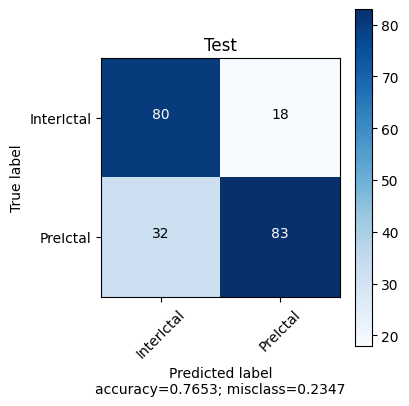

In [16]:
inputs = torch.Tensor(X_test[:,np.newaxis,:]).to(device, dtype=torch.float)
outputs = network(inputs)

outputs = outputs.cpu().detach().numpy()
outputs = np.argmax(outputs,axis=1)

plot_confusion_matrix(sklearn.metrics.confusion_matrix(outputs, np.argmax(y_test, axis=1)),
                     target_names=['InterIctal', 'PreIctal'],
                     cmap=None,
                     title='Test',
                     normalize=False)

## Accuracy

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(np.argmax(y_test, axis=1), outputs)

## Precision, recall and F1-score

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(np.argmax(y_test, axis=1), outputs)
recall = recall_score(np.argmax(y_test, axis=1), outputs)
f1 = f1_score(np.argmax(y_test, axis=1), outputs)



## Classification report

In [19]:
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), outputs, 
                               target_names=['InterIctal', 'PreIctal'])


In [20]:
print(' Precision = ', precision,'\n',
      'Accuracy = ', accuracy, '\n',
     'Recall = ', recall, '\n',
     'F1 = ', f1, '\n\n\n',
     'Classification report: \n\n', report)

 Precision =  0.7217391304347827 
 Accuracy =  0.7652582159624414 
 Recall =  0.8217821782178217 
 F1 =  0.7685185185185185 


 Classification report: 

               precision    recall  f1-score   support

  InterIctal       0.82      0.71      0.76       112
    PreIctal       0.72      0.82      0.77       101

    accuracy                           0.77       213
   macro avg       0.77      0.77      0.77       213
weighted avg       0.77      0.77      0.77       213



## Receiver operating characteristic(ROC) & Curve and area under the curve

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  # y_pred_prob is the probability of the positive class
auc = roc_auc_score(y_true, y_pred_prob)

NameError: name 'y_true' is not defined